### **CycleGAN**

CycleGAN is a generative model, which transfers the style aspects of an image to another image. Before CycleGAN networks were introduced, a pre-requisite was to train the generative model is that the each image in the training set to exist in both the source and target domain. While it is possible to manufacture this kind of dataset for some style problem settings (e.g., black and white to color photos, maps to satellite images), for others it is impossible. For example, we do not have original photographs of the pond where Monet painted his Water Lilies series, nor do we have a Picasso painting of the Empire State Building. It would also take enormous effort to arrange photos of horses and zebras standing in identical positions.

**CycleGAN contains four network, two generators and two discriminators. The first generator, G_AB, converts images from domain A into domain B. The second generator, G_BA, converts images from domain B into domain A.**

**As we do not have paired images on which to train our generators, we also need to train two discriminators that will determine if the images produced by the generators are convincing. The first discriminator, d_A, is trained to be able to identify the difference between real images from domain A and fake images that have been produced by generator G_BA. Conversely, discriminator d_B is trained to be able to identify the difference between real images from domain B and fake images that have been produced by generator G_AB.**

**CycleGAN generators take one of two forms: U-Net or ResNet (residual network).**

## New concepts

* Upsampling
* Concatenate Layers
* Instance Normalization

### **Importing Libraries**

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

from torchvision.utils import save_image
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable
import numpy as np
from collections import OrderedDict
import itertools
import os
import glob
import random

%matplotlib inline

### **Custom Dataset**

In [2]:
dir_root = './data/monet2photo/'

In [3]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.files_A = sorted(glob.glob(os.path.join(root, '%s/A' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%s/B' % mode) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
            
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))
            

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [4]:
# Dataset loader
batch_size=1
transforms_ = [transforms.RandomHorizontalFlip(),
               transforms.ToTensor()]
dataset = ImageDataset(root=dir_root, transforms_=transforms_, unaligned=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

### **Sample Image**

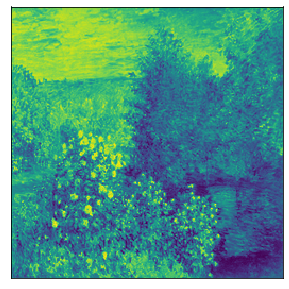

In [5]:
fig = plt.figure(figsize=(5,5))
sample = dataset[0]["A"]
plt.xticks([])
plt.yticks([])
plt.imshow(sample[0])
plt.show()

### **Custom weights initialization called on netG and netD**

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
ngpu = 1
ndc = 128
ngc = 128
nc = 3
beta1 = 0.5
num_epochs = 25
device = ('cuda' if torch.cuda.is_available else 'cpu')

### **Find the layer's dimension in each layer**

In [8]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        print(x.shape)
        return x

### **Building U-Net Generator**

In [9]:
def dconv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1),
        nn.InstanceNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True),
        #PrintLayer()
    )

In [10]:
def uconv(in_channels, out_channels):
    return nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
            #PrintLayer()
        )

In [11]:
class UNet_Generator(nn.Module):
    def __init__(self, ds):
        
        super().__init__()
        
        self.dconv_down1 = dconv(3, ds)
        self.dconv_down2 = dconv(ds, ds*2)
        self.dconv_down3 = dconv(ds*2, ds*4)
        self.dconv_down4 = dconv(ds*4, ds*8)
        
        
        self.dconv_up3 = uconv(ds*8, ds*4)
        self.dconv_up2 = uconv(ds*4*2, ds*2)
        self.dconv_up1 = uconv(ds*2*2, ds)
        
        self.upsample = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv_last = nn.Conv2d(ds*2, 3, 1)
        self.activation = nn.Tanh()
        
    def forward(self, inputs):
        
        d1 = self.dconv_down1(inputs)
        d2 = self.dconv_down2(d1)
        d3 = self.dconv_down3(d2)
        d4 = self.dconv_down4(d3)
        
        u1 = self.dconv_up3(d4)
        x = torch.cat([u1, d3], dim=1)
        
        u2 = self.dconv_up2(x)
        x = torch.cat([u2, d2], dim=1)
        
        u3 = self.dconv_up1(x)
        x = torch.cat([u3, d1], dim=1)

        x = self.upsample(x)
        x = self.conv_last(x)
        output = self.activation(x)
        
        return output

In [12]:
netG = UNet_Generator(ds=128).to(device)
netG.apply(weights_init)

UNet_Generator(
  (dconv_down1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (dconv_up3): Sequential(
    (0): UpsamplingNeares

In [13]:
numel_list = [p.numel() for p in netG.parameters()]
print(f'Total Parameters in Generator: {sum(numel_list)}')

Total Parameters in Generator: 18687491


In [14]:
# for img in dataloader:
#     img = img['A'].to(device)
#     netG(img)
#     break

### **Discriminator Network**

In [15]:
def dis_conv(in_channels, out_channels, stride, norm=True):
    if norm:
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=stride, padding=1),
            nn.InstanceNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),
            #PrintLayer()
        )
    else:
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=stride, padding=1),
            nn.ReLU(inplace=True),
            #PrintLayer()
            
        )

In [16]:
class UNet_Discriminator(nn.Module):
    def __init__(self, filters):
        super().__init__()
        self.dconv1 = dis_conv(3, filters, stride=2, norm=False)
        self.dconv2 = dis_conv(filters, filters*2, stride=2)
        self.dconv3 = dis_conv(filters*2, filters*4, stride=2)
        self.dconv4 = dis_conv(filters*4, filters*8, stride=2)
        
        self.output = nn.Conv2d(filters*8, 1, kernel_size=4, stride=1, padding=1)
        
    def forward(self, inputs):
        x = self.dconv1(inputs)
        x = self.dconv2(x)
        x = self.dconv3(x)
        x = self.dconv4(x)
        output = self.output(x)
        
        return output

In [17]:
netD = UNet_Discriminator(filters=64).to(device)
netD.apply(weights_init)

UNet_Discriminator(
  (dconv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (dconv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (dconv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (dconv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (output): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

### **Total Parameters**

In [18]:
numel_list = [p.numel() for p in netD.parameters()]
print(f'Total Parameters in Generator: {sum(numel_list)}')

Total Parameters in Generator: 2764737


### **Dummy Input**

In [19]:
# for img in dataloader:
#     img = img['A'].to(device)
#     netD(img)
#     break

In [20]:
d_A = UNet_Discriminator(filters=64).to(device)
d_A.apply(weights_init)
d_B = UNet_Discriminator(filters=64).to(device)
d_B.apply(weights_init)

UNet_Discriminator(
  (dconv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (dconv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (dconv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (dconv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (output): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

In [21]:
G_AB = UNet_Generator(ds=128).to(device)
G_AB.apply(weights_init)
G_BA = UNet_Generator(ds=128).to(device)
G_BA.apply(weights_init)

UNet_Generator(
  (dconv_down1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (dconv_up3): Sequential(
    (0): UpsamplingNeares

### **Optimizer**

In [22]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [24]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [25]:
n_epochs = 25
decay_epoch = 5

criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

optimizerD_A = optim.Adam(d_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD_B = optim.Adam(d_B.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizerG, lr_lambda=LambdaLR(n_epochs, 0, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizerD_A, lr_lambda=LambdaLR(n_epochs, 0, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizerD_B, lr_lambda=LambdaLR(n_epochs, 0, decay_epoch).step)

Tensor = torch.cuda.FloatTensor if device else torch.Tensor
target_real = Variable(Tensor(batch_size).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batch_size).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

### **Training Loop**

In [26]:
# Lists to keep track of progress

G_losses = []
DA_losses = []
DB_losses = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(n_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        optimizerG.zero_grad()
        
        img_A = data['A'].to(device)
        #print(f'img A {i} {img_A.shape}')
        img_B = data['B'].to(device)
        #print(f'img B {i} {img_B.shape}')
        
        # Identity Loss
        same_B = G_AB(img_B)
        loss_identity_B = criterion_identity(same_B, img_B) * 5.0
        
        same_A = G_BA(img_A)
        loss_identity_A = criterion_identity(same_A, img_A) * 5.0
        
        #GAN Loss
        fake_B = G_AB(img_A)
        pred_fake = d_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)
        
        fake_A = G_BA(img_B)
        pred_fake = d_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)
        
        # Cycle loss
        recovered_A = G_BA(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, img_A)*10.0

        recovered_B = G_AB(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, img_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizerG.step()
        ###################################

        ###### Discriminator A ######
        optimizerD_A.zero_grad()

        # Real loss
        pred_real = d_A(img_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = d_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizerD_A.step()
        ###################################

        ###### Discriminator B ######
        optimizerD_B.zero_grad()

        # Real loss
        pred_real = d_B(img_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = d_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizerD_B.step()
        ###################################
        
        G_losses.append(round(loss_G.item(),3))
        DA_losses.append(round(loss_D_A.item(),3))
        DB_losses.append(round(loss_D_B.item(),3))
        
    if epoch % 3 == 0:
        print(f'loss_G: {loss_G}, loss_G_identity: {loss_identity_A + loss_identity_B}, loss_G_GAN: {loss_GAN_A2B + loss_GAN_B2A},loss_G_cycle: {loss_cycle_ABA + loss_cycle_BAB}, loss_D: {loss_D_A + loss_D_B}')
        save_image(img_A, 'real_A'+str(epoch)+'.png')
        save_image(img_B, 'real_B'+str(epoch)+'.png')
        save_image(fake_A, 'fake_A'+str(epoch)+'.png')
        save_image(fake_B, 'fake_B'+str(epoch)+'.png')
    
    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Save models checkpoints
    torch.save(G_AB.state_dict(), 'output/G_AB.pth')
    torch.save(G_BA.state_dict(), 'output/G_BA.pth')
    torch.save(d_A.state_dict(), 'output/d_A.pth')
    torch.save(d_B.state_dict(), 'output/d_B.pth')

Starting Training Loop...


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 15, 15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_G: 6.306726455688477, loss_G_identity: 1.390678882598877, loss_G_GAN: 1.720977544784546,loss_G_cycle: 3.195070505142212, loss_D: 0.04599841684103012
loss_G: 5.502340793609619, loss_G_identity: 1.174161672592163, loss_G_GAN: 1.9845001697540283,loss_G_cycle: 2.343679189682007, loss_D: 0.004426902160048485
loss_G: 5.041806221008301, loss_G_identity: 1.042305588722229, loss_G_GAN: 1.8788846731185913,loss_G_cycle: 2.1206157207489014, loss_D: 0.005506507121026516
loss_G: 4.838458061218262, loss_G_identity: 0.919938325881958, loss_G_GAN: 2.0932953357696533,loss_G_cycle: 1.8252243995666504, loss_D: 0.0047943550162017345
loss_G: 3.9227399826049805, loss_G_identity: 0.5360358953475952, loss_G_GAN: 2.0395922660827637,loss_G_cycle: 1.3471118211746216, loss_D: 0.0009210961870849133
loss_G: 3.684213399887085, loss_G_identity: 0.599679708480835, loss_G_GAN: 2.002216339111328,loss_G_cycle: 1.0823171138763428, loss_D: 0.000378063996322453
loss_G: 3.363706588745117, loss_G_identity: 0.4136578738689

In [26]:
gen_imgs = np.concatenate([img_A.detach().cpu(), fake_B.detach().cpu(), img_B.detach().cpu(), fake_A.detach().cpu()])

In [27]:
def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)